## Hartree-Fock in Pytorch

We use the Hartree-Fock method to rotate the single particle basis and get the NSM Hamiltonian in that framework. Using this rotation we investigate the quasiparticle framework.

#### Imports

In [1]:
from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim

# we select the file with the single particle states and the twobody matrix elements
file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Compute the twobody dictionary in the form $V[(a,b,c,d)]=$ value

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.93it/s]


#### Hyperparameters to select the Nucleus

In [3]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)

#### Get the NSM Hamiltonians using the FermiHubbardHamiltonian class from NSMFermions

In [4]:

# Initialize the Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# intiialize the single particle part
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# initialize the twobody part using the optimized method
NSMHamiltonian.get_twobody_interaction_optimized(twobody_dict=twobody_matrix)
# get the full matrix representation
NSMHamiltonian.get_hamiltonian()
# get the spectrum
eigvals,eigvects=NSMHamiltonian.get_spectrum(n_states=10)

# investigate the spectrum
print(eigvals)

# we ge the dimension of the Hamiltonian
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/numba/typed/typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to uint64. Precision may be lost.
  return d[key]


Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:01<00:00, 978.57it/s] 

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-30.29539461 -26.88369692 -19.0041005  -15.86699708 -15.31298892
 -14.49860676 -13.61172347 -13.41558684 -12.80630663 -12.62779145]
dimension= 51


#### Hartree-Fock optimization using pytorch

In [5]:
# we initialize the Hartree-Fock model as a pytorch module
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

E1: 7.620481414829669, E2: -11.096953004134377, E_constrain: 0.0
Step    0 | Energy = -3.476472
E1: 7.6007216310727586, E2: -11.273936150217466, E_constrain: 0.0
E1: 7.579593894469405, E2: -11.460056037004378, E_constrain: 0.0
E1: 7.557108682722142, E2: -11.65455052558281, E_constrain: 0.0
E1: 7.533267940304297, E2: -11.856718246921648, E_constrain: 0.0
E1: 7.508079715175496, E2: -12.06603866108976, E_constrain: 0.0
E1: 7.481626028098479, E2: -12.282027456825437, E_constrain: 0.0
E1: 7.4540694692923966, E2: -12.503894669993125, E_constrain: 0.0
E1: 7.42559732206327, E2: -12.73050955053707, E_constrain: 0.0
E1: 7.396397471876525, E2: -12.960547978031787, E_constrain: 0.0
E1: 7.366657419338576, E2: -13.192606268494414, E_constrain: 0.0
E1: 7.336565445246071, E2: -13.425270673385887, E_constrain: 0.0
E1: 7.306309847941708, E2: -13.657165070533193, E_constrain: 0.0
E1: 7.276076609395724, E2: -13.886987757694522, E_constrain: 0.0
E1: 7.246046060969951, E2: -14.11354173296473, E_constrain: 0

#### check the symmetry

In [6]:
print(np.sum(m_values*model.rho_n.detach().numpy()),np.sum(m_values*model.rho_p.detach().numpy()))

0.17964050237082158 0.17964048623775158


#### Compute the basis rotation operator out of the Fock operators

In [12]:
# get the single particle component of the hamiltonian in matrix form
singleparticle_part_matrix=torch.diag(model.h)

# get the fock operators for neutrons and protons
fock_operator_n,fock_operator_p=model.build_fock_matrices_factorized()
# get the unitaries
_, unitary_n = torch.linalg.eigh(fock_operator_n)   # columns of U_can are eigenvectors
_, unitary_p = torch.linalg.eigh(fock_operator_p)   # columns of U_can are eigenvectors
# build the full unitary
unitary=torch.zeros((size_a+size_b,size_a+size_b),dtype=torch.double)
unitary[:size_a,:size_a]=unitary_n
unitary[size_a:,size_a:]=unitary_p
new_single_particle_matrix_torch,new_twobody_matrix_torch=model.transform_integrals_using_fock_rotation(unitary.T,singleparticle_part_matrix,model.V_tensor)
print(new_single_particle_matrix_torch.shape)

torch.Size([12, 12])


In [13]:
new_energies=np.diag(new_single_particle_matrix_torch.detach().numpy())
print(new_energies)

new_twobody_matrix={}
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        for c in range(size_a+size_b):
            for d in range(size_a+size_b):
                if np.abs(new_twobody_matrix_torch[a,b,c,d].detach().numpy())>=10**-7:
                    new_twobody_matrix[(a,b,c,d)]=new_twobody_matrix_torch[a,b,c,d].detach().numpy()

[1.79000695 1.79000695 1.63       1.63       2.10999305 2.10999305
 1.79000695 1.79000695 1.63       1.63       2.10999305 2.10999305]


Let's see the new twobody matrix elements

1424 5360


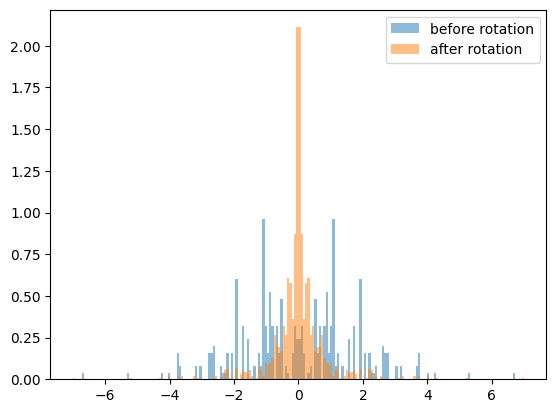

In [14]:
values_twobody_matrix=list(twobody_matrix.values())
values_twobody_matrix_after_rotation=list(new_twobody_matrix.values())
print(len(values_twobody_matrix),len(values_twobody_matrix_after_rotation))
plt.hist(values_twobody_matrix,bins=200,alpha=0.5,label='before rotation',density=True,range=(-7,7))
plt.hist(values_twobody_matrix_after_rotation,bins=200,alpha=0.5,label='after rotation',density=True,range=(-7,7))
plt.legend()
plt.show()


As you can see we get an important localization in the values, this can be useful for many algorithms such as Krylov with QDrift and VQEs

#### Let's build the NSM Hamiltonian in the fock basis

In [15]:
#### we still decompose in neutrons and protons because HF conserves these numbers
NSMFockHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
# one body term:
one_body_term=0.
for a in range(size_a+size_b):
    for b in range(size_a+size_b):
        one_body_term+=new_single_particle_matrix_torch[a,b].detach().numpy()*NSMFockHamiltonian.adag_a_matrix_optimized(a,b)

# initialize the Hamiltonian as in the NSM case
NSMFockHamiltonian.get_twobody_interaction_optimized(new_twobody_matrix)
NSMFockHamiltonian.get_hamiltonian()
NSMFockHamiltonian.hamiltonian+=one_body_term
eigvals_hf,psis_hf=NSMFockHamiltonian.get_spectrum(10)

print(eigvals_hf)


Building two-body operator with 5360 terms...


100%|██████████| 5360/5360 [00:00<00:00, 13292.24it/s]

✅ Two-body operator built: shape=(225, 225), nnz=16805
[-30.29539461 -26.88369694 -26.88369692 -26.88369692 -26.88369691
 -26.8836969  -19.00410054 -19.00410052 -19.00410051 -19.0041005 ]


In [16]:
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp

QPC=QuasiParticlesConverterOnlynnpp()
QPC.initialize_shell(state_encoding=SPS.state_encoding)
QPC.get_the_basis_matrix_transformation(NSMHamiltonian.basis)


QPCHF=QuasiParticlesConverterOnlynnpp()
QPCHF.initialize_shell(state_encoding=SPS.state_encoding)


new_couples=[]
for i in range(0,size_a,2):

    new_couples.append([i+6,i+7])
    new_couples.append([i,i+1])
    #new_couples.append([i,i+6])
    #new_couples.append([i+1,i+7])
    
    


    
QPCHF.couples=new_couples


QPCHF.get_the_basis_matrix_transformation(NSMFockHamiltonian.basis)

print(QPCHF.quasiparticle_basis.shape)


(9, 6)


In [17]:
print(QPC.quasiparticle_basis.shape)
hamiltonian_Q=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
egsQ,psi_Q=eigsh(hamiltonian_Q,k=5,which='SA')

hamiltonian_QHF=QPCHF.particles2quasiparticles @ NSMFockHamiltonian.hamiltonian @ QPCHF.particles2quasiparticles.T
egsQnp,psi_Qnp=eigsh(hamiltonian_QHF,k=5,which='SA')

# print the eigenvalues
print(egsQnp,egsQ)






print('\n')

# we sum the contribution of all the eigenstates of the QPHF Hamiltonian to the HF ground state
fs=[]
for i in range(egsQnp.shape[0]):
    # project the quasiparticle eigenvector back to the full Fock space
    psi_Qnp2particle=QPCHF.particles2quasiparticles.T @ psi_Qnp[:,i]
    psi_Qnp2particle/=np.linalg.norm(psi_Qnp2particle)
    # plot the fidelities for each eigenvector
    print(psis_hf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psis_hf[:,0].dot(psi_Qnp2particle.conj())))#,j_values[i])
    fs.append(psis_hf[:,0].dot(psi_Qnp2particle.conj())*np.conjugate(psis_hf[:,0].dot(psi_Qnp2particle.conj())))
print('\n')
print(np.sum(fs),'\n')
# we sum the contribution of all the eigenstates of the QP Hamiltonian to the NSM ground state
fs=[]
for i in range(egsQ.shape[0]):
    # project the quasiparticle eigenvector back to the full Fock space
    psi_Q2particle=QPC.particles2quasiparticles.T @ psi_Q[:,i]
    psi_Q2particle/=np.linalg.norm(psi_Q2particle)
    # plot the fidelities for each eigenvector
    print(eigvects[:,0].dot(psi_Q2particle.conj())*np.conjugate(eigvects[:,0].dot(psi_Q2particle.conj())))#,j_values[0])
    fs.append(eigvects[:,0].dot(psi_Q2particle.conj())*np.conjugate(eigvects[:,0].dot(psi_Q2particle.conj())))
print('\n')
print(np.sum(fs))


(9, 6)
[-26.09584583 -20.50675433 -12.50918186 -11.48643896  -9.53260906] [-20.3041178  -17.43478828 -12.52467658 -10.67469442  -6.97037031]


0.2770960971189949
0.34871192534143425
0.02006139826694209
7.190218067150407e-22
4.453824530333871e-20


0.6458694207273713 

0.5758878400309743
7.850603243730851e-33
4.6042336316470505e-32
0.009593520332546535
0.0008179919153660357


0.5862993522788869
